# Million Song Subset Exploration

In the present notebook we perform a first analysis on a subset of the million song dataset.
This subset is available [here](https://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset).

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
import sqlite3

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15)
sb.set_palette('Dark2')
sb.set_style('whitegrid')
path = '../MillionSongSubset/'

# Reading SQL tables

For this demo all database ``.db`` files are in a separate folder named ``AdditionalFiles/``.
An alternative to the lines below is a demo available at https://labrosa.ee.columbia.edu/millionsong/sites/default/files/tutorial1.py.txt that was tailored specifically for reading these files.

In [3]:
con_simi = sqlite3.connect(path+'AdditionalFiles/subset_artist_similarity.db')
con_term = sqlite3.connect(path+'AdditionalFiles/subset_artist_term.db')
con_meta = sqlite3.connect(path+'AdditionalFiles/subset_track_metadata.db')

cur_simi = con_simi.cursor()
cur_term = con_term.cursor()
cur_meta = con_meta.cursor()

First we need to find out the table names in each of our files:

In [4]:
# subset_artist_similarity.db
res = con_simi.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

artists
similarity


In [5]:
# subset_artist_term.db
res = con_term.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

artists
terms
artist_term
mbtags
artist_mbtag


In [6]:
# subset_track_metadata.db
res = con_meta.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

songs


# Exploring the Metadata tables

In [8]:
songs = pd.read_sql_query('SELECT * FROM songs WHERE year!=0', con_meta)
songs.head(5)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,2001
1,TRACCMH128F428E4CD,No Quieras Marcharte,SOGDQZK12A8C13F37C,Adelante,AR2PT4M1187FB55B1A,d54ea4a6-0b9c-4e47-bed0-289ae9ff4037,Los Chichos,191.68608,0.561590,0.420570,1984
2,TRACCVS12903D014F8,Ad Te Clamamus Exsvles Mortva Liberi,SOHCCIA12AC907577F,Pentagrammaton,ARZEWUR1187FB53DC8,0be59867-0da4-4e45-9b64-728cdf25487c,Enthroned,89.15546,0.593416,0.395710,2010
3,TRACCKS128F42B77AE,Murder One,SOBOAQC12A8C13E3E9,BTNHRESURRECTION,ARUZRFN1187B98AC05,2fa45bbb-0efb-4950-9d40-94bf23cbfec1,Bone Thugs-N-Harmony,255.73832,0.815923,0.555138,2000
4,TRACCJA128F149A144,Segredo,SODPNJR12A6D4FA52D,Joao Voz E Violato,AR3THYK1187B999F1F,286ec4c2-b5ca-4f85-b331-280a6d73dd14,João Gilberto,197.19791,0.645192,0.471224,2000


In [12]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 11 columns):
track_id              4680 non-null object
title                 4680 non-null object
song_id               4680 non-null object
release               4680 non-null object
artist_id             4680 non-null object
artist_mbid           4680 non-null object
artist_name           4680 non-null object
duration              4680 non-null float64
artist_familiarity    4680 non-null float64
artist_hotttnesss     4680 non-null float64
year                  4680 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 402.3+ KB


In [41]:
songs_per_yr = songs.year.value_counts()[songs.year.value_counts().index > 1954].sort_index()
songs_per_yr.head(5)

1955    1
1956    7
1957    1
1958    6
1959    9
Name: year, dtype: int64

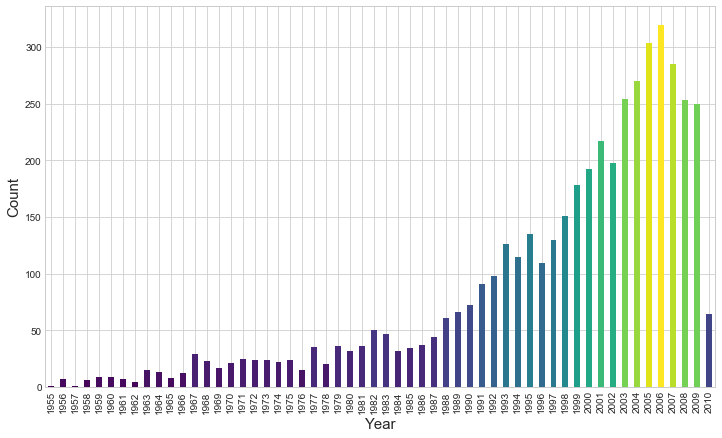

In [70]:
l_col = songs_per_yr / songs_per_yr.max()
songs_per_yr.plot.bar(color=cm.viridis(l_col), figsize=(12,7))

plt.xlabel('Year')
plt.ylabel('Count');

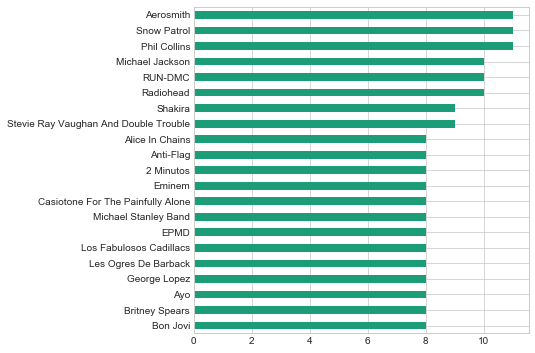

In [72]:
songs_per_artist = songs.artist_name.value_counts()
songs_per_artist[songs_per_artist >= 8].sort_values().plot.barh(color='C0', figsize=(6,6));

In [73]:
songs.duration.describe()

count    4680.000000
mean      238.781146
std       101.345438
min         1.044440
25%       181.152200
50%       227.382400
75%       278.406080
max      1598.197100
Name: duration, dtype: float64

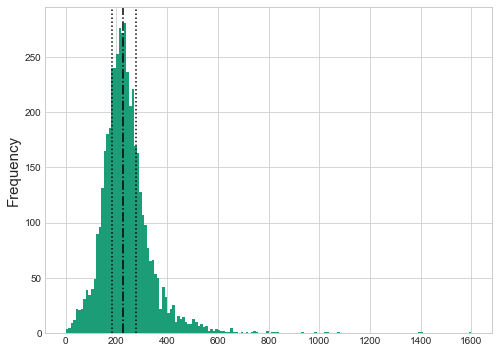

In [86]:
songs.duration.plot.hist(bins=np.arange(0.0, 1610.0, 10.0))
plt.axvline(181.1522, linestyle=':', c='k')
plt.axvline(227.3824, linestyle='-.', c='k')
plt.axvline(278.40608, linestyle=':', c='k');

In [92]:
songs[['artist_hotttnesss','artist_familiarity']].describe()

,artist_hotttnesss,artist_familiarity
count,4680.000000,4680.000000
mean,0.441711,0.631585
std,0.128043,0.140808
min,0.000000,0.000000
25%,0.366820,0.540750
50%,0.420938,0.622875
75%,0.511054,0.727230
max,1.082503,1.000000


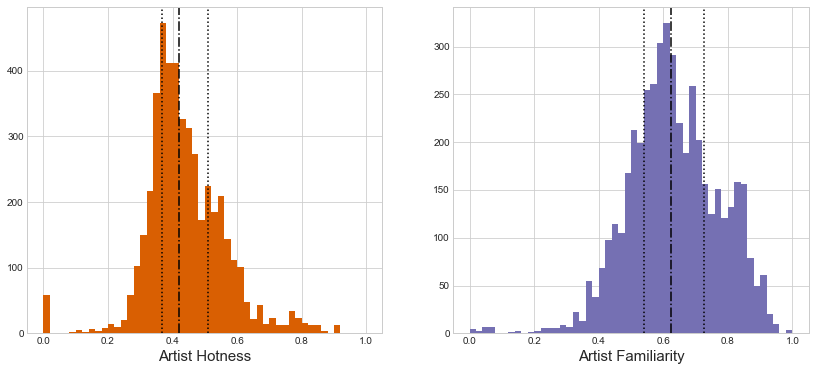

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharex=True)

songs.artist_hotttnesss.hist(bins=np.linspace(0.0,1.0,51), ax=ax[0], color='C1');
ax[0].set_xlabel('Artist Hotness')
ax[0].axvline(0.36682, linestyle=':', c='k')
ax[0].axvline(0.420938, linestyle='-.', c='k')
ax[0].axvline(0.511054, linestyle=':', c='k')

songs.artist_familiarity.hist(bins=np.linspace(0.0,1.0,51), ax=ax[1], color='C2');
ax[1].set_xlabel('Artist Familiarity')
ax[1].axvline(0.54075, linestyle=':', c='k')
ax[1].axvline(0.622875, linestyle='-.', c='k')
ax[1].axvline(0.72723, linestyle=':', c='k');

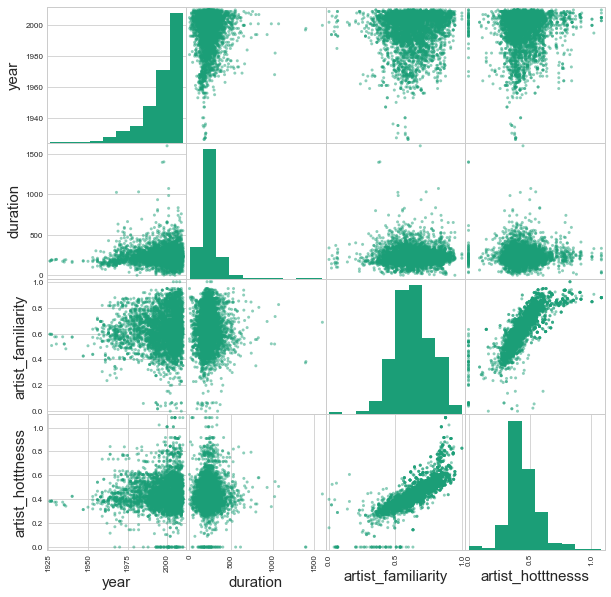

In [163]:
pd.plotting.scatter_matrix(songs[['year','duration','artist_familiarity','artist_hotttnesss']],
                           figsize=(10,10));

### Scatter plots of artist_familiarity vs year compared to artist_hotttnesss vs year

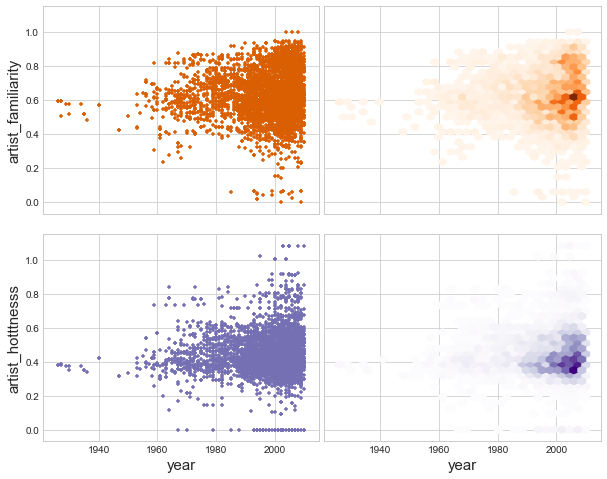

In [144]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                       figsize=(10,8))

songs.plot.scatter(x='year', y='artist_familiarity', marker='+', ax=ax[0,0], color='C1')
songs.plot.hexbin(x='year', y='artist_familiarity', cmap='Oranges', ax=ax[0,1],
                  gridsize=31, mincnt=1.0, colorbar=False)

songs.plot.scatter(x='year', y='artist_hotttnesss', marker='+', ax=ax[1,0], color='C2')
songs.plot.hexbin(x='year', y='artist_hotttnesss', cmap='Purples', ax=ax[1,1],
                  gridsize=31, mincnt=1.0, colorbar=False);
plt.subplots_adjust(wspace=0.02, hspace=0.1)

### Artist_hotttnesss vs artist familiarity

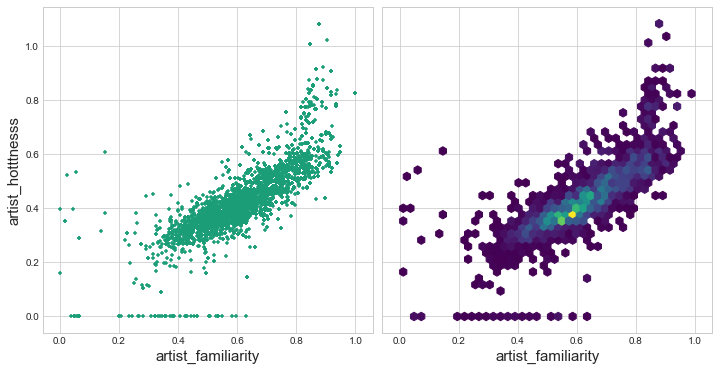

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(12,6))

songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', marker='+', ax=ax[0])
songs.plot.hexbin(x='artist_familiarity', y='artist_hotttnesss', ax=ax[1],
                  gridsize=41, mincnt=1.0, cmap='viridis', colorbar=False)

plt.subplots_adjust(wspace=0.03);

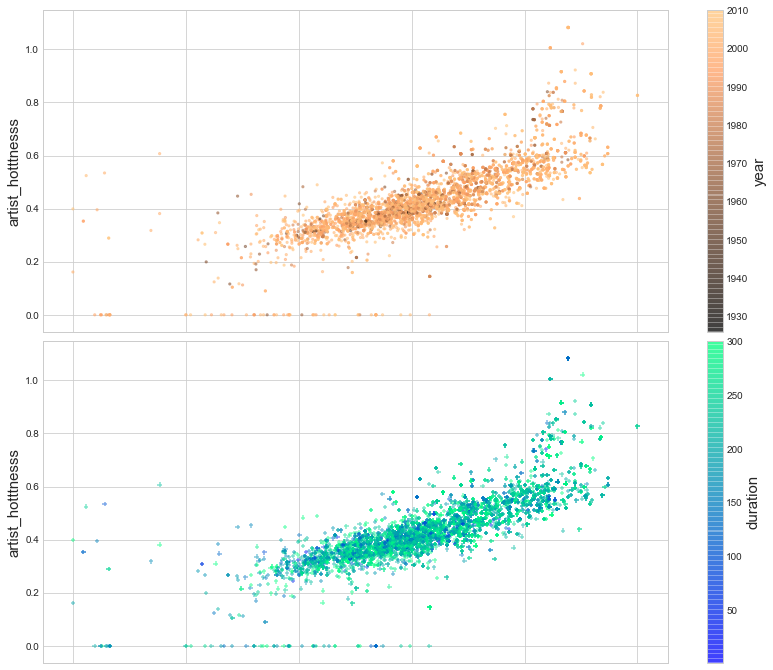

In [156]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True,
                       figsize=(14,12))

songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', c='year',
                   marker='.', ax=ax[0], cmap='copper', alpha=0.5)
songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', c='duration',
                   marker='+', ax=ax[1], cmap='winter', vmax=300, alpha=0.5)

plt.subplots_adjust(hspace=0.03);

In [175]:
songs_eminem = songs.query("artist_name=='Eminem'")

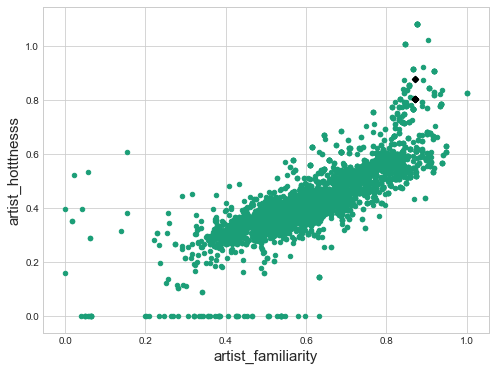

In [184]:
ax = songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', marker='o')
songs_eminem.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', marker='D', color='k', ax=ax)

### Artist_familiarity compared to artist_hotttnesss over time

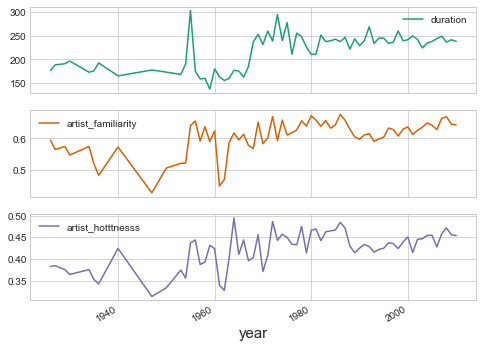

In [167]:
tmp = songs.groupby('year').mean()
tmp.plot(subplots=True);